In [37]:
import utility
from tqdm import tqdm
import os
from sklearn.cluster import KMeans
import pyvista as pv
import pandas as pd
import numpy as np
from IPython.display import Image
from collections import defaultdict
from scipy.spatial import KDTree
from scipy import stats
import math
import matplotlib.pyplot as plt

In [38]:
import importlib
importlib.reload(utility)

<module 'utility' from '/home/simon/knorpel_v2/utility.py'>

Disable shortcuts
<script>Jupyter.keyboard_manager.disable()</script>

In [39]:
# sitk_image, np_image = utility.read_image('/home/simon/Pictures/9001104/9001104_segm.mhd')
sitk_image, np_image = utility.read_image('/home/simon/Pictures/9255535/9255535_segm.mhd')

In [40]:
femoral_cartilage = utility.build_3d_cartilage_array(np_image, 3)
tibial_cartilage = utility.build_3d_cartilage_array(np_image, 4)

femoral_vectors = [list(element) for element in femoral_cartilage]
tibial_vectors = [list(element) for element in tibial_cartilage]

In [5]:
p = pv.Plotter()

x, y, z, xy = utility.get_xyz(tibial_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
p.add_mesh(pv.PolyData(df.to_numpy()), color='red')

x, y, z, xy = utility.get_xyz(femoral_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
p.add_mesh(pv.PolyData(df.to_numpy()), color='green')

tmp_vectors = utility.build_3d_cartilage_array(np_image, 1)
x, y, z, xy = utility.get_xyz(tmp_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
p.add_mesh(pv.PolyData(df.to_numpy()), color='blue')

tmp_vectors = utility.build_3d_cartilage_array(np_image, 2)
x, y, z, xy = utility.get_xyz(tmp_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
p.add_mesh(pv.PolyData(df.to_numpy()), color='yellow')

p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Tibia

In [5]:
x, y, z, xy = utility.get_xyz(tibial_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])

In [6]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(df.to_numpy()))
p.show_grid()
p.show()
p.render()
p.save_graphic('s1.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Approach:
Construct an upper and a lower mesh out of the cartilage volume and calculate the distance between the meshes (by raytracing, nearest neighbors, etc). To this end, group by x, y coordinates and for each pair (x, y), take the maximum z coordinate for the upper mesh and the minimum z coordinate for the lower mesh.

In [7]:
max_z = df.groupby(['x', 'y']).max()
min_z = df.groupby(['x', 'y']).min()

tmp1 = [np.array(item) for item in max_z.index]
tmp2 = [item for item in max_z.to_numpy()]
max_z = np.column_stack((tmp1, tmp2))

tmp1 = [np.array(item) for item in min_z.index]
tmp2 = [item for item in min_z.to_numpy()]
min_z = np.column_stack((tmp1, tmp2))

In [8]:
upper_cloud = pv.PolyData(max_z)
lower_cloud = pv.PolyData(min_z)

In [9]:
p = pv.Plotter()
p.add_mesh(upper_cloud, color='green')
p.add_mesh(lower_cloud, color='red')
p.add_mesh(pv.PolyData(df.to_numpy()), color='blue', opacity=0.25)
p.add_legend([['bone-sided mesh', 'green'], ['cartilage-sided mesh', 'red']])
p.show_grid()
p.show()
p.render()
p.save_graphic('tibial_points.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [10]:
# build polygon meshes for both point clouds using delaunay
lower_mesh = lower_cloud.delaunay_2d()
upper_mesh = upper_cloud.delaunay_2d()

We can now calculate the distance between the two meshes. In this example, we simply calculate the mean total distance using a k-d tree nearest neighbor search. For division into subregions, it is better to do raytracing from one mesh's normal vectors against the other mesh.

In [11]:
from scipy.spatial import KDTree

tree = KDTree(upper_cloud.points)
d, idx = tree.query(lower_cloud.points)
lower_cloud['distances'] = d
np.mean(d)

2.7352430942075143

In [12]:
importlib.reload(utility)

<module 'utility' from '/home/simon/knorpel_v2/utility.py'>

In [13]:
dd = defaultdict(list)
left_tibial_regions, right_tibial_regions, split_vector = utility.tibial_landmarks(lower_mesh.points)
for v in tqdm(lower_mesh.points):
    vector = np.array(v)
    # print(vector)
    label = utility.classify_tibial_point(vector[:2], left_tibial_regions, right_tibial_regions, split_vector)
    dd[label].append(vector)

dd.keys()

100%|█████████████████████████████████████| 8357/8357 [00:01<00:00, 6517.26it/s]


dict_keys(['aLT', 'iLT', 'aMT', 'eLT', 'iMT', 'eMT', 'cLT', 'cMT', 'pLT', 'pMT'])

In [14]:
left_tibial_regions

[[137, 31],
 [267, 31],
 [267, 74],
 [137, 74],
 17.0,
 array([203.42889544,  54.05171241])]

In [15]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(dd['eLT']), color='red')
p.add_mesh(pv.PolyData(dd['pLT']), color='blue')
p.add_mesh(pv.PolyData(dd['cLT']), color='green')
p.add_mesh(pv.PolyData(dd['aLT']), color='pink')
p.add_mesh(pv.PolyData(dd['iLT']), color='yellow')
p.add_mesh(pv.PolyData(dd['eMT']), color='red')
p.add_mesh(pv.PolyData(dd['pMT']), color='blue')
p.add_mesh(pv.PolyData(dd['cMT']), color='green')
p.add_mesh(pv.PolyData(dd['aMT']), color='pink')
p.add_mesh(pv.PolyData(dd['iMT']), color='yellow')
p.add_legend([['external', 'red'], ['posterior', 'blue'], ['anterior', 'pink'], ['internal', 'yellow'], ['central', 'green']])
p.add_title('Subregions of the tibial cartilage')
p.show_grid()
p.show()
p.render()
p.save_graphic('tibial_subregions.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Femur

In [7]:
x, y, z, xy = utility.get_xyz(femoral_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])

In [17]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(df.to_numpy()))
p.show_grid()
p.show()
p.render()
p.save_graphic('s2.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Approach:
Using the same approach as for the tibial cartilage is not possible due to the volume's shape. Let's illustrate the problem: <br><br>
Instead of going by z coordinate, it makes more sense to take a central point and introduce a distance measure to that point.

In [37]:
center = np.array([df.x.min() + (df.x.max() - df.x.min()) / 2,
                   df.y.min() + (df.y.max() - df.y.min()) / 2,
                   df.z.min() + (df.z.max() - df.z.min()) / 2])

df['dist_to_cog'] = np.zeros(df.shape[0])
df['dist_to_cog'] = df.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center), axis=1)
df

,x,y,z,dist_to_cog
0,170,0,52,93.364876
1,171,0,52,94.180677
2,169,0,53,92.504054
3,170,0,53,93.316665
4,171,0,53,94.132885
...,...,...,...,...
122282,139,108,99,81.884064
122283,140,108,99,82.437855
122284,141,108,99,83.000000
122285,142,108,99,83.570330


If we now again group by x, y and take the min/max distance...

In [38]:
max_z = df[df.groupby(['x', 'y'])['dist_to_cog'].transform(max) == df['dist_to_cog']]
min_z = df[df.groupby(['x', 'y'])['dist_to_cog'].transform(min) == df['dist_to_cog']]

max_z = [item[:3] for item in max_z.to_numpy()]
min_z = [item[:3] for item in min_z.to_numpy()]

In [39]:
upper_cloud = pv.PolyData(max_z)
lower_cloud = pv.PolyData(min_z)

In [40]:
p = pv.Plotter()
p.add_mesh(upper_cloud, color='red')
p.add_mesh(lower_cloud, color='green')
p.add_mesh(pv.PolyData(df.to_numpy()[:,0:3]), color='blue', opacity=0.25)
p.add_legend([['bone-sided mesh', 'green'], ['cartilage-sided mesh', 'red']])
p.show_grid()
p.show()
p.render()
p.save_graphic('femoral_points.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

This is what we get. You can see that points are missing in the curved regions. This makes sense because we only take one value each for each (x, y) while for these regions, we'd need >= 2 values for the inner and outer mesh.<br><br>
Another way to approach this problem is again taking a central point, and from this point do raytracing against the cartilage volume. For each tracing vector, find the first and last intersection point with the volume (if any) and calculate the distance between the two.<br><br>
To this end, we can build a sphere and trace along the sphere's normal vectors.

In [41]:
num_sp = 30
sphere = pv.Sphere(center=center, radius=1, theta_resolution=num_sp, phi_resolution=num_sp)
sphere.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x7f41a8b8fe20)
  N Cells:	1680
  N Points:	842
  X Bounds:	9.300e+01, 9.500e+01
  Y Bounds:	5.301e+01, 5.499e+01
  Z Bounds:	5.600e+01, 5.800e+01
  N Arrays:	1

In [42]:
p = pv.Plotter()
m = pv.PolyData(df.to_numpy()[:,0:3])
p.add_mesh(m, color='red')
p.add_mesh(sphere, color='green')
# p.add_mesh(sphere.glyph(scale='Normals', orient='Normals', tolerance=0.05), color='blue')
p.add_arrows(sphere.points, sphere['Normals'], 25)
p.show_grid()
p.add_title('Sphere placement for the femoral cartilage')
p.show()
p.render()
p.save_graphic('femoral_sphere.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Fixing the mesh approach
Another approach that might work is cutting the full volume into two shapes and rotating the problematic section. Let's have a look:

In [43]:
df = df.sort_values(by='x', ascending=True)
zrange = df.groupby(by=['x'])['z'].max() - df.groupby(by=['x'])['z'].min()
zrange.describe()

count    189.000000
mean      47.878307
std       30.161286
min       13.000000
25%       28.000000
50%       32.000000
75%       58.000000
max      112.000000
Name: z, dtype: float64

In [44]:
zmed = zrange.median()

In [45]:
from scipy import stats

In [46]:
zindex = zrange.loc[zrange < zmed].index.to_numpy()
mask = np.abs(stats.zscore(zindex)) < 2
lower_bound = zindex[mask].min()
upper_bound = zindex[mask].max()

In [47]:
#lower_bound = 35
#upper_bound = 122
print(lower_bound, upper_bound)

35 122


In [48]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(df.loc[df['x'] > lower_bound].loc[df['x'] < upper_bound].to_numpy()[:,0:3]), color='blue', opacity=0.25)
p.add_mesh(pv.PolyData(df.loc[df['x'] < lower_bound].to_numpy()[:,0:3]), color='red', opacity=0.25)
p.add_mesh(pv.PolyData(df.loc[df['x'] > upper_bound].to_numpy()[:,0:3]), color='yellow', opacity=0.25)
p.show()
p.render()
p.save_graphic('s3.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [49]:
right_portion = df.loc[df['x'] < lower_bound]
right_portion = right_portion[['z', 'y', 'x', 'dist_to_cog']]
right_portion.columns = ['x', 'y', 'z', 'dist_to_cog']

middle_portion = df.loc[df['x'] > lower_bound].loc[df['x'] < upper_bound]

left_portion = df.loc[df['x'] > upper_bound]
left_portion = left_portion[['z', 'y', 'x', 'dist_to_cog']]
left_portion.columns = ['x', 'y', 'z', 'dist_to_cog']

In [50]:
pv.plot(pv.PolyData(left_portion.to_numpy()[:,0:3]), color='yellow')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [51]:
pv.plot(pv.PolyData(right_portion.to_numpy()[:,0:3]), color='red')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [52]:
max_z = left_portion[left_portion.groupby(['x', 'y'])['dist_to_cog'].transform(max) == left_portion['dist_to_cog']]
min_z = left_portion[left_portion.groupby(['x', 'y'])['dist_to_cog'].transform(min) == left_portion['dist_to_cog']]

max_z = [item[:3] for item in max_z.to_numpy()]
min_z = [item[:3] for item in min_z.to_numpy()]

In [53]:
outer_cloud = pv.PolyData(max_z)
inner_cloud = pv.PolyData(min_z)

In [54]:
p = pv.Plotter()
p.add_mesh(inner_cloud, color='red', opacity=.5)
p.add_mesh(outer_cloud, color='blue', opacity=.5)
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [55]:
outer_delaunay = outer_cloud.delaunay_2d()
inner_delaunay = inner_cloud.delaunay_2d()

In [56]:
p = pv.Plotter()
p.add_mesh(inner_delaunay, color='red', opacity=.5)
p.add_mesh(outer_delaunay, color='blue', opacity=.5)
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

This seems to work all right. Let's do some raytracing.

In [57]:
def build_delaunay(portion):
    max_dist = portion[portion.groupby(['x', 'y'])['dist_to_cog'].transform(max) == portion['dist_to_cog']]
    min_dist = portion[portion.groupby(['x', 'y'])['dist_to_cog'].transform(min) == portion['dist_to_cog']]

    max_dist = [item[:3] for item in max_dist.to_numpy()]
    min_dist = [item[:3] for item in min_dist.to_numpy()]
    
    outer_cloud = pv.PolyData(max_dist)
    inner_cloud = pv.PolyData(min_dist)
    
    return outer_cloud.delaunay_2d(), inner_cloud.delaunay_2d()

In [58]:
left_outer, left_inner = build_delaunay(left_portion)
middle_outer, middle_inner = build_delaunay(middle_portion)
right_outer, right_inner = build_delaunay(right_portion)

In [59]:
left_out = left_outer.copy()
left_out.points = np.array([[x[2], x[1], x[0]] for x in left_out.points])
left_in = left_inner.copy()
left_in.points = np.array([[x[2], x[1], x[0]] for x in left_in.points])

middle_out = middle_outer.copy()
middle_out.points = np.array([[x[0], x[1], x[2]] for x in middle_out.points])
middle_in = middle_inner.copy()
middle_in.points = np.array([[x[0], x[1], x[2]] for x in middle_in.points])

right_out = right_outer.copy()
right_out.points = np.array([[x[2], x[1], x[0]] for x in right_out.points])
right_in = right_inner.copy()
right_in.points = np.array([[x[2], x[1], x[0]] for x in right_in.points])

In [60]:
p = pv.Plotter()
p.add_mesh(left_out, color='red')
p.add_mesh(middle_out, color='red')
p.add_mesh(right_out, color='red')
p.add_mesh(left_in, color='green')
p.add_mesh(middle_in, color='green')
p.add_mesh(right_in, color='green')
p.show_grid()
p.add_legend([['bone-sided mesh', 'green'], ['cartilage-sided mesh', 'red']])
p.add_title('Succesful construction of meshes for the femoral cartilage', font_size=10)

p.show()
p.render()
p.save_graphic('femoral_meshes.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [61]:
cluster = KMeans(n_clusters=1, random_state=0).fit(femoral_vectors)
split_vector = cluster.cluster_centers_[0]
femoral_split_vector = split_vector
left_plate, right_plate = utility.split_into_plates(femoral_vectors, split_vector)

first_split, second_split = utility.get_femoral_thirds(left_plate)
left_femoral_regions = [first_split, second_split]

first_split, second_split = utility.get_femoral_thirds(right_plate)
right_femoral_regions = [first_split, second_split]

In [62]:
def ray_trace(inner, outer):
    average_thickness = dict()
    n_points = inner.n_points
    average_thickness['ecLF'] = np.zeros(n_points)
    average_thickness['ccLF'] = np.zeros(n_points)
    average_thickness['icLF'] = np.zeros(n_points)
    average_thickness['icMF'] = np.zeros(n_points)
    average_thickness['ccMF'] = np.zeros(n_points)
    average_thickness['ecMF'] = np.zeros(n_points)
    
    inner_normals = inner.compute_normals(cell_normals=False)
    inner_normals['distances'] = np.zeros(inner.n_points)
    for i in range(inner_normals.n_points):
        v = inner.points[i]
        vec = inner_normals['Normals'][i] * inner_normals.length
        v0 = v - vec
        v1 = v + vec
        iv, ic = outer.ray_trace(v0, v1, first_point=True)
        dist = np.sqrt(np.sum((iv - v)**2))
        inner_normals['distances'][i] = dist
        label = utility.classify_femoral_point(v[:2], left_femoral_regions, right_femoral_regions, split_vector)
        average_thickness[label][i] = dist
    
    return average_thickness

In [63]:
left_thickness = ray_trace(left_inner, left_outer)
middle_thickness = ray_trace(middle_inner, middle_outer)
right_thickness = ray_trace(right_inner, right_outer)

In [64]:
average_thickness = {key: np.hstack((left_thickness[key], middle_thickness[key], right_thickness[key])) for key in left_thickness.keys()}

In [65]:
for key, value in average_thickness.items():
    mask = value == 0
    value[mask] = np.nan
    print(f'{key}: {np.nanmean(value)}')

ecLF: 4.129961834403946
ccLF: 5.005532149065432
icLF: 5.453199175673108
icMF: 6.514685954736944
ccMF: 4.35446237196326
ecMF: 3.9881449550694197


In [66]:
from collections import defaultdict


In [67]:
importlib.reload(utility)

<module 'utility' from '/home/simon/knorpel_v2/utility.py'>

In [68]:
df.to_numpy()[:,:3]

array([[  0.,  88.,  44.],
       [  0.,  90.,  48.],
       [  0.,  89.,  45.],
       ...,
       [188.,  18.,  54.],
       [188.,  23.,  53.],
       [188.,  13.,  38.]])

In [69]:
dd = defaultdict(list)
for vector in tqdm(df.to_numpy()[:,:3]):
    label = utility.classify_femoral_point(vector[:2], left_femoral_regions, right_femoral_regions, split_vector)
    dd[label].append(vector)

100%|███████████████████████████████| 122287/122287 [00:00<00:00, 307646.13it/s]


In [70]:
dd.keys()

dict_keys(['ccMF', 'ecMF', 'icMF', 'icLF', 'ccLF', 'ecLF'])

In [71]:
print(left_femoral_regions, right_femoral_regions, split_vector)

[22, 34] [77, 88] [ 75.94043521  55.95815581 110.1472356 ]


In [72]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(dd['ecLF']), color='red')
p.add_mesh(pv.PolyData(dd['icLF']), color='yellow')
p.add_mesh(pv.PolyData(dd['ccLF']), color='green')
p.add_mesh(pv.PolyData(dd['icMF']), color='pink')
p.add_mesh(pv.PolyData(dd['ecMF']), color='red')
p.add_mesh(pv.PolyData(dd['ccMF']), color='green')
p.show_grid()
p.add_legend([['external', 'red'], ['central', 'green'], ['internal (left)', 'yellow'], ['internal (right)', 'pink']])
p.add_title('Subregions of the femoral cartilage')
p.show()
p.render()
p.save_graphic('femoral_subregions.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Combine outer clouds for the regional classification

In [73]:
ldf = pd.DataFrame(data=left_outer.points, columns=['x', 'y', 'z'])
mdf = pd.DataFrame(data=middle_outer.points, columns=['x', 'y', 'z'])
rdf = pd.DataFrame(data=right_outer.points, columns=['x', 'y', 'z'])

ldf = ldf[['z', 'y', 'x']]
ldf.columns = ['x', 'y', 'z']

rdf = rdf[['z', 'y', 'x']]
rdf.columns = ['x', 'y', 'z']

cdf = pd.concat([ldf, mdf, rdf])

In [74]:
# outer_stack = np.vstack((left_outer.points, middle_outer.points, right_outer.points))
pv.PolyData(cdf.to_numpy()).plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Sphere approach for the tibial cartilage
Because why not?

In [80]:
x, y, z, xy = utility.get_xyz(tibial_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])

In [81]:
center = np.array([df.x.min() + (df.x.max() - df.x.min()) / 2,
                   df.y.min() + (df.y.max() - df.y.min()) / 2,
                   df.z.max() * 1.25])
                   #df.z.min() + (df.z.max() - df.z.min()) / 2])

df['dist_to_cog'] = np.zeros(df.shape[0])
df['dist_to_cog'] = df.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center), axis=1)
df

,x,y,z,dist_to_cog
0,76,0,23,57.768936
1,77,0,23,57.976288
2,78,0,23,58.200086
3,79,0,23,58.440140
4,62,0,24,56.375970
...,...,...,...,...
35793,68,108,23,56.720807
35794,69,108,23,56.791285
35795,70,108,23,56.879258
35796,71,108,23,56.984647


In [82]:
num_sp = 30
sphere = pv.Sphere(center=center, radius=1, theta_resolution=num_sp, phi_resolution=num_sp)
sphere.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x7fb82466ee20)
  N Cells:	1680
  N Points:	842
  X Bounds:	6.350e+01, 6.550e+01
  Y Bounds:	5.301e+01, 5.499e+01
  Z Bounds:	3.900e+01, 4.100e+01
  N Arrays:	1

In [86]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(df.to_numpy()[:,0:3]), color='red')
p.add_mesh(sphere, color='green')
# p.add_mesh(sphere.glyph(scale='Normals', orient='Normals', tolerance=0.05), color='blue')
p.add_arrows(sphere.points, sphere['Normals'], 5)
p.show_grid()
p.add_title('Sphere placement for the tibial cartilage')
p.show()
p.render()
p.save_graphic('tibial_sphere.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Extraction of the weight-bearing zone of the femoral cartilage

In [25]:
femoral_cartilage_new = [0] * (np_image.shape[0] * np_image.shape[1] * np_image.shape[2])
tibial_cartilage_new = [0] * (np_image.shape[0] * np_image.shape[1] * np_image.shape[2])
tindx = 0
findx = 0
for y in tqdm(range(np_image.shape[0])):
    for x in range(np_image.shape[1]):
        for z in range(np_image.shape[2]):
            if np_image[y,x,z] == 3:
                femoral_cartilage_new[findx] = [x, y, z]
                findx += 1
            if np_image[y,x,z] == 4:
                tibial_cartilage_new[tindx] = [x, y, z]
                tindx += 1

femoral_cartilage_new = np.array(femoral_cartilage_new, dtype=object)
femoral_cartilage_new = femoral_cartilage_new[femoral_cartilage_new != 0] 
femoral_cartilage_new = [list(element) for element in femoral_cartilage_new]

tibial_cartilage_new = np.array(tibial_cartilage_new, dtype=object)
tibial_cartilage_new = tibial_cartilage_new[tibial_cartilage_new != 0] 
tibial_cartilage_new = [list(element) for element in tibial_cartilage_new]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [02:45<00:00,  1.04s/it]


In [26]:
x, y, z, xy = utility.get_xyz(tibial_cartilage_new)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
max_z = df.groupby(['x', 'y']).max()
min_z = df.groupby(['x', 'y']).min()

tmp1 = [np.array(item) for item in max_z.index]
tmp2 = [item for item in max_z.to_numpy()]
max_z = np.column_stack((tmp1, tmp2))

tmp1 = [np.array(item) for item in min_z.index]
tmp2 = [item for item in min_z.to_numpy()]
min_z = np.column_stack((tmp1, tmp2))

upper_cloud = pv.PolyData(max_z)

dd = defaultdict(list)
left_tibial_regions, right_tibial_regions, split_vector = utility.tibial_landmarks(max_z)
for v in tqdm(max_z):
    vector = np.array(v)
    # print(vector)
    label = utility.classify_tibial_point(vector[:2], left_tibial_regions, right_tibial_regions, split_vector)
    dd[label].append(vector)

dd.keys()

100%|███████████████████████████████████████████████████████████████████████████████████████| 11110/11110 [00:01<00:00, 7093.24it/s]


dict_keys(['aLT', 'iLT', 'aMT', 'eLT', 'eMT', 'iMT', 'cLT', 'cMT', 'pLT', 'pMT'])

In [27]:
wbl = np.vstack((np.array(dd['eLT']), np.array(dd['cLT']), np.array(dd['iLT'])))
wbr = np.vstack((np.array(dd['iMT']), np.array(dd['cMT']), np.array(dd['eMT'])))

In [28]:
tdfr = pd.DataFrame(data={'x': wbr[:,0], 'y': wbr[:,1], 'z': wbr[:,2]})
tdfl = pd.DataFrame(data={'x': wbl[:,0], 'y': wbl[:,1], 'z': wbl[:,2]})

In [29]:
print(max(np.array(dd['cMT'])[:,0]), max(np.array(dd['eMT'])[:,0]), max(np.array(dd['iMT'])[:,0]))

245 265 278


In [30]:
tdfr = tdfr.loc[tdfr['x'] < max(np.array(dd['cMT'])[:,0])].loc[tdfr['x'] > min(np.array(dd['cMT'])[:,0])]
tdfl = tdfl.loc[tdfl['x'] < max(np.array(dd['cLT'])[:,0])].loc[tdfl['x'] > min(np.array(dd['cLT'])[:,0])]

In [31]:
x, y, z, xy = utility.get_xyz(femoral_cartilage_new)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
fdfl = df.loc[df['y'] < df['y'].mean()]
fdfr = df.loc[df['y'] >= df['y'].mean()]

In [32]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(fdfl.to_numpy()), color='blue')
p.add_mesh(pv.PolyData(fdfr.to_numpy()), color='purple')
p.add_mesh(pv.PolyData(tdfl.to_numpy()), color='green')
p.add_mesh(pv.PolyData(tdfr.to_numpy()), color='yellow')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [33]:
tree = KDTree(tdfl.to_numpy())
d, idx = tree.query(fdfl.to_numpy())
d

array([ 99.70456359, 100.24968828,  99.02524931, ...,  22.04540769,
        21.42428529,  20.83266666])

In [34]:
# wbz = np.array(femoral_cartilage_new)[np.where(d < 10)]
wbz = np.array(fdfl.to_numpy()[np.where(d < 10)])

In [35]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(fdfl.to_numpy()), color='blue')
p.add_mesh(pv.PolyData(tdfl.to_numpy()), color='green')
p.add_mesh(pv.PolyData(wbz), color='red')
#p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [36]:
minx = tdfl['x'].min()
maxx = tdfl['x'].max()
miny = tdfl['y'].min()
maxy = tdfl['y'].max()
wbz = fdfl.loc[fdfl['x'] > minx].loc[fdfl['x'] < maxx].loc[fdfl['y'] > miny].loc[fdfl['y'] < maxy].to_numpy()

In [37]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(fdfl.to_numpy()), color='blue')
p.add_mesh(pv.PolyData(tdfl.to_numpy()), color='green')
p.add_mesh(pv.PolyData(fdfr.to_numpy()), color='orange')
p.add_mesh(pv.PolyData(wbz), color='red')
#p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# New approach for the femur

In [5]:
importlib.reload(utility)

<module 'utility' from '/home/simon/knorpel_v2/utility.py'>

In [6]:
cwbzl, cwbzr = utility.extract_central_weightbearing_zone(femoral_vectors, tibial_vectors)

In [7]:
x, y, z, xy = utility.get_xyz(femoral_vectors)
df = pd.DataFrame(data={'x': z, 'y': y, 'z': x}, columns=['x', 'y', 'z'])
p = pv.Plotter()
p.add_mesh(pv.PolyData(df.to_numpy()))
p.add_mesh(pv.PolyData(cwbzl.to_numpy()), color='red')
p.add_mesh(pv.PolyData(cwbzr.to_numpy()), color='green')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
lower_mesh_left, upper_mesh_left = utility.build_femoral_meshes(cwbzl)
lower_mesh_right, upper_mesh_right = utility.build_femoral_meshes(cwbzr)

In [10]:
p = pv.Plotter()
p.add_mesh(lower_mesh_left, color='red')
p.add_mesh(lower_mesh_right, color='blue')
p.add_mesh(upper_mesh_left, color='green')
p.add_mesh(upper_mesh_right, color='purple')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [11]:
p = pv.Plotter()
p.add_mesh(lower_mesh_left, color='red')
p.add_mesh(lower_mesh_right, color='blue')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [12]:
p = pv.Plotter()
p.add_mesh(upper_mesh_left, color='green')
p.add_mesh(upper_mesh_right, color='purple')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
left_landmarks = utility.femoral_landmarks(upper_mesh_left.points)
right_landmarks = utility.femoral_landmarks(upper_mesh_right.points)

In [14]:
left_left_portion = cwbzl.loc[cwbzl['y'] < left_landmarks[0]]
left_middle_portion = cwbzl.loc[cwbzl['y'] >= left_landmarks[0]].loc[cwbzl['y'] < left_landmarks[1]]
left_right_portion = cwbzl.loc[cwbzl['y'] >= left_landmarks[1]]

In [15]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(left_left_portion.to_numpy()), color='blue')
p.add_mesh(pv.PolyData(left_middle_portion.to_numpy()), color='red')
p.add_mesh(pv.PolyData(left_right_portion.to_numpy()), color='green')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [16]:
left_right_portion = left_right_portion[['z', 'y', 'x']]
left_right_portion.columns = ['x', 'y', 'z']

In [17]:
left_portion_lower_mesh, left_portion_upper_mesh = utility.build_tibial_meshes(left_left_portion.to_numpy())
middle_portion_lower_mesh, middle_portion_upper_mesh = utility.build_tibial_meshes(left_middle_portion.to_numpy())
right_portion_lower_mesh, right_portion_upper_mesh = utility.build_tibial_meshes(left_right_portion.to_numpy())

In [18]:
p = pv.Plotter()
p.add_mesh(left_portion_lower_mesh, color='blue')
p.add_mesh(middle_portion_lower_mesh, color='red')
p.add_mesh(right_portion_lower_mesh, color='green')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [19]:
dd = defaultdict(list)
for vector in tqdm(cwbzl.to_numpy()[:,:3]):
    label = utility.classify_femoral_point(vector[:2], left_landmarks, True)
    dd[label].append(vector)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10120/10120 [00:00<00:00, 441887.18it/s]


In [20]:
dd.keys()

dict_keys(['ecLF', 'ccLF', 'icLF'])

In [21]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(dd['ecLF']), color='red')
p.add_mesh(pv.PolyData(dd['icLF']), color='yellow')
p.add_mesh(pv.PolyData(dd['ccLF']), color='green')
p.show_grid()
p.add_legend([['external', 'red'], ['central', 'green'], ['internal (left)', 'yellow'], ['internal (right)', 'pink']])
p.add_title('Subregions of the femoral cartilage')
p.show()
# p.render()
# p.save_graphic('femoral_subregions.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [22]:
dd = defaultdict(list)
for vector in tqdm(cwbzr.to_numpy()[:,:3]):
    label = utility.classify_femoral_point(vector[:2], right_landmarks, False)
    dd[label].append(vector)

100%|█████████████████████████████████████████████████████████████████████████████████████| 11410/11410 [00:00<00:00, 417214.52it/s]


In [23]:
dd.keys()

dict_keys(['icMF', 'ccMF', 'ecMF'])

In [24]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(dd['icMF']), color='pink')
p.add_mesh(pv.PolyData(dd['ecMF']), color='red')
p.add_mesh(pv.PolyData(dd['ccMF']), color='green')
p.show_grid()
p.add_legend([['external', 'red'], ['central', 'green'], ['internal (left)', 'yellow'], ['internal (right)', 'pink']])
p.add_title('Subregions of the femoral cartilage')
p.show()
# p.render()
# p.save_graphic('femoral_subregions.svg')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [25]:
left_thickness = dict()
left_thickness['ecLF'] = np.zeros(lower_mesh_left.n_points)
left_thickness['ccLF'] = np.zeros(lower_mesh_left.n_points)
left_thickness['icLF'] = np.zeros(lower_mesh_left.n_points)

right_thickness = dict()
right_thickness['icMF'] = np.zeros(lower_mesh_right.n_points)
right_thickness['ccMF'] = np.zeros(lower_mesh_right.n_points)
right_thickness['ecMF'] = np.zeros(lower_mesh_right.n_points)

left_normals = lower_mesh_left.compute_normals(cell_normals=False)
right_normals = lower_mesh_right.compute_normals(cell_normals=False)

_, left_thickness = utility.calculate_femoral_thickness(left_normals, lower_mesh_left, upper_mesh_left, sitk_image, left_landmarks, left_thickness, True)
_, right_thickness = utility.calculate_femoral_thickness(right_normals, lower_mesh_right, upper_mesh_right, sitk_image, right_landmarks, right_thickness, False)

In [26]:
femoral_thickness = dict()
femoral_thickness.update(left_thickness)
femoral_thickness.update(right_thickness)

In [27]:
femoral_thickness

{'ecLF': array([18.14957944,  4.18986655,  3.04591173, ...,  0.        ,
         0.        ,  0.        ]),
 'ccLF': array([0., 0., 0., ..., 0., 0., 0.]),
 'icLF': array([0.      , 0.      , 0.      , ..., 4.199988, 2.799992, 0.699998]),
 'icMF': array([0.699998, 0.699998, 1.399996, ..., 0.      , 0.      , 0.      ]),
 'ccMF': array([0., 0., 0., ..., 0., 0., 0.]),
 'ecMF': array([0., 0., 0., ..., 0., 0., 0.])}

In [28]:
keys = set(femoral_thickness.keys())
for key in keys:
    value = femoral_thickness[key]
    mask = value == 0
    value[mask] = np.nan
    femoral_thickness[key + '.aSD'] = np.nanstd(value)
    femoral_thickness[key + '.aMav'] = np.nanmean(-np.sort(-value)[:math.ceil(len(value) * 0.01)])
    femoral_thickness[key + '.aMiv'] = np.nanmean(np.sort(value)[:math.ceil(len(value) * 0.01)])
    femoral_thickness[key] = np.nanmean(value)

In [29]:
femoral_thickness

{'ecLF': 3.8171511474057933,
 'ccLF': 5.515698179776914,
 'icLF': 3.9921458975019375,
 'icMF': 3.203264268879522,
 'ccMF': 5.989148381375881,
 'ecMF': 3.763880590630727,
 'icMF.aSD': 1.1406065762772055,
 'icMF.aMav': 5.116829016211624,
 'icMF.aMiv': 0.6999980000000002,
 'icLF.aSD': 1.3112522511015228,
 'icLF.aMav': 7.846349845604406,
 'icLF.aMiv': 1.1483024553966663,
 'ccLF.aSD': 0.6186535828990887,
 'ccLF.aMav': 6.5132478854586076,
 'ccLF.aMiv': 4.023842286645824,
 'ecLF.aSD': 2.1233391343485226,
 'ecLF.aMav': 12.394485600891374,
 'ecLF.aMiv': 1.6293572242965175,
 'ecMF.aSD': 1.594080513659783,
 'ecMF.aMav': 7.909195241629887,
 'ecMF.aMiv': 1.4350302038795786,
 'ccMF.aSD': 0.7224685980286254,
 'ccMF.aMav': 7.32548619929081,
 'ccMF.aMiv': 4.393036184290812}

In [30]:
importlib.reload(utility)

<module 'utility' from '/home/simon/knorpel_v2/utility.py'>

In [31]:
ladf, radf, pdf = utility.extract_anterior_posterior_zones(femoral_vectors, cwbzl, cwbzr)

In [32]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(ladf.to_numpy()), color='red')
p.add_mesh(pv.PolyData(radf.to_numpy()), color='green')
p.add_mesh(pv.PolyData(pdf.to_numpy()), color='blue')
# p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [33]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(ladf.to_numpy()), color='red')
p.add_mesh(pv.PolyData(radf.to_numpy()), color='green')
p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [34]:
la_lower_mesh, la_upper_mesh = utility.build_tibial_meshes(ladf.to_numpy())
ra_lower_mesh, ra_upper_mesh = utility.build_tibial_meshes(radf.to_numpy())
p_lower_mesh, p_upper_mesh = utility.build_tibial_meshes(pdf.to_numpy())

In [35]:
p = pv.Plotter()
p.add_mesh(la_lower_mesh, color='red')
p.add_mesh(la_upper_mesh, color='orange')
p.add_mesh(ra_lower_mesh, color='green')
p.add_mesh(ra_upper_mesh, color='cyan')
p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [36]:
p = pv.Plotter()
p.add_mesh(p_lower_mesh, color='red')
p.add_mesh(p_upper_mesh, color='green')
p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [37]:
la_normals = la_lower_mesh.compute_normals(cell_normals=False)
ra_normals = ra_lower_mesh.compute_normals(cell_normals=False)
p_normals = p_lower_mesh.compute_normals(cell_normals=False)

la_distances = utility.calculate_distance_without_classification(la_normals, la_lower_mesh, la_upper_mesh, sitk_image)
ra_distances = utility.calculate_distance_without_classification(ra_normals, ra_lower_mesh, ra_upper_mesh, sitk_image)
p_distances = utility.calculate_distance_without_classification(p_normals, p_lower_mesh, p_upper_mesh, sitk_image)

In [38]:
la_distances['distances']

array([0.        , 1.89497042, 3.5505721 , ..., 0.        , 0.        ,
       0.        ])

In [39]:
la_thickness = dict()
distances = la_distances['distances']
mask = distances == 0
distances[mask] = np.nan
la_thickness['aLF.aSD'] = np.nanstd(distances)
la_thickness['aLF.aMav'] = np.nanmean(-np.sort(-distances)[:math.ceil(len(distances) * 0.01)])
la_thickness['aLF.aMiv'] = np.nanmean(np.sort(distances)[:math.ceil(len(distances) * 0.01)])
la_thickness['aLF'] = np.nanmean(distances)

In [40]:
la_thickness

{'aLF.aSD': 2.8245065220366943,
 'aLF.aMav': 23.15468043175688,
 'aLF.aMiv': 1.3057824532524103,
 'aLF': 4.773370276932947}

In [41]:
ra_thickness = dict()
distances = ra_distances['distances']
mask = distances == 0
distances[mask] = np.nan
ra_thickness['aMF.aSD'] = np.nanstd(distances)
ra_thickness['aMF.aMav'] = np.nanmean(-np.sort(-distances)[:math.ceil(len(distances) * 0.01)])
ra_thickness['aMF.aMiv'] = np.nanmean(np.sort(distances)[:math.ceil(len(distances) * 0.01)])
ra_thickness['aMF'] = np.nanmean(distances)

In [42]:
ra_thickness

{'aMF.aSD': 1.9579087515350613,
 'aMF.aMav': 13.409865537279831,
 'aMF.aMiv': 0.9729198950689117,
 'aMF': 4.364521041284879}

In [43]:
p_thickness = dict()
distances = p_distances['distances']
mask = distances == 0
distances[mask] = np.nan
p_thickness['pF.aSD'] = np.nanstd(distances)
p_thickness['pF.aMav'] = np.nanmean(-np.sort(-distances)[:math.ceil(len(distances) * 0.01)])
p_thickness['pF.aMiv'] = np.nanmean(np.sort(distances)[:math.ceil(len(distances) * 0.01)])
p_thickness['pF'] = np.nanmean(distances)

In [44]:
p_thickness

{'pF.aSD': 5.104802586798915,
 'pF.aMav': 47.71493741287999,
 'pF.aMiv': 0.7433645494243941,
 'pF': 4.512998589901148}

# Changes to the femur for the sphere approach

In [121]:
cwbzl, cwbzr = utility.extract_central_weightbearing_zone(femoral_vectors, tibial_vectors)
center_left = np.array([cwbzl.x.min() + (cwbzl.x.max() - cwbzl.x.min()) / 2,
                    cwbzl.y.min() + (cwbzl.y.max() - cwbzl.y.min()) / 2,
                    cwbzl.z.min() - (cwbzl.z.max() - cwbzl.z.min()) / 4])

center_right = np.array([cwbzr.x.min() + (cwbzr.x.max() - cwbzr.x.min()) / 2,
                    cwbzr.y.min() + (cwbzr.y.max() - cwbzr.y.min()) / 2,
                    cwbzr.z.min() - (cwbzr.z.max() - cwbzr.z.min()) / 4])

In [122]:
lower_mesh_left, upper_mesh_left = utility.build_femoral_meshes(cwbzl)
lower_mesh_right, upper_mesh_right = utility.build_femoral_meshes(cwbzr)

left_landmarks = utility.femoral_landmarks(upper_mesh_left.points)
right_landmarks = utility.femoral_landmarks(upper_mesh_right.points)

In [123]:
sphere_left = pv.Sphere(center=center_left, radius=1, theta_resolution=60, phi_resolution=60)
sphere_right = pv.Sphere(center=center_right, radius=1, theta_resolution=60, phi_resolution=60)

In [124]:
cwbzl['dist'] = np.zeros(cwbzl.shape[0])
cwbzl['dist'] = cwbzl.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center_left), axis=1)

cwbzr['dist'] = np.zeros(cwbzr.shape[0])
cwbzr['dist'] = cwbzr.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center_left), axis=1)

In [125]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(cwbzl.to_numpy()[:,:3]), color='red')
p.add_mesh(pv.PolyData(cwbzr.to_numpy()[:,:3]), color='green')
p.add_mesh(sphere_left, color='orange')
p.add_mesh(sphere_right, color='cyan')
#p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [126]:
sphere_left.compute_normals(point_normals=True, cell_normals=False, inplace=True)
sphere_right.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x7f6f69487e20)
  N Cells:	6960
  N Points:	3482
  X Bounds:	2.260e+02, 2.280e+02
  Y Bounds:	1.115e+02, 1.135e+02
  Z Bounds:	1.762e+02, 1.782e+02
  N Arrays:	1

In [127]:
sphere_left_iter = np.array([[np.nan, np.nan]] * sphere_left.n_points, dtype='object')
sphere_right_iter = np.array([[np.nan, np.nan]] * sphere_right.n_points, dtype='object')

In [128]:
from functools import partial
from multiprocessing import Pool
import sphere

In [129]:
for i in range(sphere_left.n_points):
    sphere_left_iter[i,0] = tuple(sphere_left.points[i])
    sphere_left_iter[i,1] = tuple(sphere_left['Normals'][i])

In [130]:
for i in range(sphere_right.n_points):
    sphere_right_iter[i,0] = tuple(sphere_right.points[i])
    sphere_right_iter[i,1] = tuple(sphere_right['Normals'][i])

In [131]:
with Pool() as pool:
    res = pool.starmap(partial(sphere.vector_trace, df=cwbzl), iterable=sphere_left_iter)

In [132]:
res = np.array(res, dtype='object')
res = res[res != None]
res

array([list([array([213.,  42., 210.]), array([215.,  42., 220.])]),
       list([array([196.,  40., 211.]), array([195.,  38., 215.])]),
       list([array([197.,  40., 211.]), array([195.,  38., 216.])]), ...,
       list([array([210.,  40., 212.]), array([207.,  38., 221.])]),
       list([array([211.,  40., 212.]), array([208.,  38., 221.])]),
       list([array([211.,  40., 212.]), array([209.,  38., 221.])])],
      dtype=object)

In [133]:
inner_points = [item[0] for item in res]
outer_points = [item[1] for item in res]

In [134]:
left_thickness = dict()
left_thickness['ecLF'] = np.zeros(len(outer_points))
left_thickness['ccLF'] = np.zeros(len(outer_points))
left_thickness['icLF'] = np.zeros(len(outer_points))

In [135]:
for i in range(len(outer_points)):
    label = utility.classify_femoral_point(outer_points[i][:2], left_landmarks, True)
    left_thickness[label][i] = utility.vector_distance(inner_points[i], outer_points[i]) * sitk_image.GetSpacing()[2]

In [136]:
with Pool() as pool:
    res = pool.starmap(partial(sphere.vector_trace, df=cwbzr), iterable=sphere_right_iter)
    
res = np.array(res, dtype='object')
res = res[res != None]

inner_points = [item[0] for item in res]
outer_points = [item[1] for item in res]

right_thickness = dict()
right_thickness['icMF'] = np.zeros(len(outer_points))
right_thickness['ccMF'] = np.zeros(len(outer_points))
right_thickness['ecMF'] = np.zeros(len(outer_points))

for i in range(len(outer_points)):
    label = utility.classify_femoral_point(outer_points[i][:2], right_landmarks, False)
    right_thickness[label][i] = utility.vector_distance(inner_points[i], outer_points[i]) * sitk_image.GetSpacing()[2]

In [137]:
femoral_thickness = dict()
femoral_thickness.update(left_thickness)
femoral_thickness.update(right_thickness)

In [142]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(inner_points), color='red')
p.add_mesh(pv.PolyData(outer_points), color='green')
p.add_mesh(sphere_right, color='blue')
p.add_mesh(sphere_left, color='cyan')
# p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [141]:
len(inner_points), len(outer_points)

(1250, 1250)

In [144]:
lpdf, rpdf, adf = utility.extract_anterior_posterior_zones(femoral_vectors, cwbzl, cwbzr)

In [154]:
center_lp = np.array([lpdf.x.min() + (lpdf.x.max() - lpdf.x.min()) / 4,
                    lpdf.y.min() + (lpdf.y.max() - lpdf.y.min()) / 2,
                    lpdf.z.min() + (lpdf.z.max() - lpdf.z.min()) / 2])

center_rp = np.array([rpdf.x.min() + (rpdf.x.max() - rpdf.x.min()) / 4,
                    rpdf.y.min() + (rpdf.y.max() - rpdf.y.min()) / 2,
                    rpdf.z.min() + (rpdf.z.max() - rpdf.z.min()) / 2])

center_a = np.array([adf.x.min() + ((adf.x.max() - adf.x.min()) / 4) * 3,
                    adf.y.min() + (adf.y.max() - adf.y.min()) / 2,
                    adf.z.min() + (adf.z.max() - adf.z.min()) / 4])

In [155]:
sphere_lp = pv.Sphere(center=center_lp, radius=1, theta_resolution=60, phi_resolution=60)
sphere_rp = pv.Sphere(center=center_rp, radius=1, theta_resolution=60, phi_resolution=60)
sphere_a = pv.Sphere(center=center_a, radius=1, theta_resolution=60, phi_resolution=60)

In [156]:
lpdf['dist'] = np.zeros(lpdf.shape[0])
lpdf['dist'] = lpdf.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center_lp), axis=1)

rpdf['dist'] = np.zeros(rpdf.shape[0])
rpdf['dist'] = rpdf.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center_rp), axis=1)

adf['dist'] = np.zeros(adf.shape[0])
adf['dist'] = adf.apply(lambda l: utility.vector_distance([l.x, l.y, l.z], center_a), axis=1)

In [157]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(lpdf.to_numpy()[:,:3]), color='red')
p.add_mesh(pv.PolyData(rpdf.to_numpy()[:,:3]), color='green')
p.add_mesh(pv.PolyData(adf.to_numpy()[:,:3]), color='yellow')
p.add_mesh(sphere_lp, color='orange')
p.add_mesh(sphere_rp, color='cyan')
p.add_mesh(sphere_a, color='pink')
#p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [158]:
sphere_lp.compute_normals(point_normals=True, cell_normals=False, inplace=True)
sphere_rp.compute_normals(point_normals=True, cell_normals=False, inplace=True)
sphere_a.compute_normals(point_normals=True, cell_normals=False, inplace=True)

PolyData (0x7f6f621be3a0)
  N Cells:	6960
  N Points:	3482
  X Bounds:	1.783e+02, 1.802e+02
  Y Bounds:	7.700e+01, 7.900e+01
  Z Bounds:	1.275e+02, 1.295e+02
  N Arrays:	1

In [159]:
sphere_lp_iter = np.array([[np.nan, np.nan]] * sphere_lp.n_points, dtype='object')
sphere_rp_iter = np.array([[np.nan, np.nan]] * sphere_rp.n_points, dtype='object')
sphere_a_iter = np.array([[np.nan, np.nan]] * sphere_a.n_points, dtype='object')

In [160]:
for i in range(sphere_lp.n_points):
    sphere_lp_iter[i,0] = tuple(sphere_lp.points[i])
    sphere_lp_iter[i,1] = tuple(sphere_lp['Normals'][i])

for i in range(sphere_rp.n_points):
    sphere_rp_iter[i,0] = tuple(sphere_rp.points[i])
    sphere_rp_iter[i,1] = tuple(sphere_rp['Normals'][i])

for i in range(sphere_a.n_points):
    sphere_a_iter[i,0] = tuple(sphere_a.points[i])
    sphere_a_iter[i,1] = tuple(sphere_a['Normals'][i])

In [161]:
with Pool() as pool:
    res = pool.starmap(partial(sphere.vector_trace, df=lpdf), iterable=sphere_lp_iter)
    
res = np.array(res, dtype='object')
res = res[res != None]

inner_points = [item[0] for item in res]
outer_points = [item[1] for item in res]

femoral_thickness['pLF'] = np.zeros(len(outer_points))

for i in range(len(outer_points)):
    femoral_thickness['pLF'][i] = utility.vector_distance(inner_points[i], outer_points[i]) * sitk_image.GetSpacing()[2]

In [ ]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(inner_points), color='red')
p.add_mesh(pv.PolyData(outer_points), color='green')
p.add_mesh(sphere_lp, color='blue')
# p.show_grid()
p.show()

In [165]:
with Pool() as pool:
    res = pool.starmap(partial(sphere.vector_trace, df=rpdf), iterable=sphere_rp_iter)
    
res = np.array(res, dtype='object')
res = res[res != None]

inner_points = [item[0] for item in res]
outer_points = [item[1] for item in res]

femoral_thickness['pMF'] = np.zeros(len(outer_points))

for i in range(len(outer_points)):
    femoral_thickness['pMF'][i] = utility.vector_distance(inner_points[i], outer_points[i]) * sitk_image.GetSpacing()[2]

In [ ]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(inner_points), color='red')
p.add_mesh(pv.PolyData(outer_points), color='green')
p.add_mesh(sphere_rp, color='blue')
# p.show_grid()
p.show()

In [166]:
with Pool() as pool:
    res = pool.starmap(partial(sphere.vector_trace, df=adf), iterable=sphere_a_iter)
    
res = np.array(res, dtype='object')
res = res[res != None]

inner_points = [item[0] for item in res]
outer_points = [item[1] for item in res]

femoral_thickness['aF'] = np.zeros(len(outer_points))

for i in range(len(outer_points)):
    femoral_thickness['aF'][i] = utility.vector_distance(inner_points[i], outer_points[i]) * sitk_image.GetSpacing()[2]

In [167]:
p = pv.Plotter()
p.add_mesh(pv.PolyData(inner_points), color='red')
p.add_mesh(pv.PolyData(outer_points), color='green')
p.add_mesh(sphere_a, color='blue')
# p.show_grid()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
keys = set(femoral_thickness.keys())
for key in keys:
    value = femoral_thickness[key]
    mask = value == 0
    value[mask] = np.nan
    femoral_thickness[key + '.aSD'] = np.nanstd(value)
    femoral_thickness[key + '.aMav'] = np.nanmean(-np.sort(-value)[:math.ceil(len(value) * 0.01)])
    femoral_thickness[key + '.aMiv'] = np.nanmean(np.sort(value)[:math.ceil(len(value) * 0.01)])
    femoral_thickness[key] = np.nanmean(value)

In [170]:
femoral_thickness

{'ecLF': 4.254168576809634,
 'ccLF': 6.98313953815472,
 'icLF': 5.42020835149045,
 'icMF': 4.020005189361094,
 'ccMF': 6.806959055555063,
 'ecMF': 4.631621072368648,
 'icMF.aSD': 1.5098571893847004,
 'icMF.aMav': 6.959003755903373,
 'icMF.aMiv': 0.6999980000000001,
 'icLF.aSD': 1.6873368230091055,
 'icLF.aMav': 8.428010913231645,
 'icLF.aMiv': 1.9332429172746155,
 'ccLF.aSD': 0.8994741129404458,
 'ccLF.aMav': 8.251420462140674,
 'ccLF.aMiv': 2.966937508604229,
 'ecLF.aSD': 1.4068313959033591,
 'ecLF.aMav': 6.446578327200137,
 'ecLF.aMiv': 2.308594170076343,
 'ecMF.aSD': 1.8001236463621781,
 'ecMF.aMav': 7.357524924372445,
 'ecMF.aMiv': 1.4628052421806157,
 'ccMF.aSD': 1.5702833774469591,
 'ccMF.aMav': 8.54996391789425,
 'ccMF.aMiv': 1.2444025862480939,
 'pLF': 4.8483454651144,
 'pLF.aSD': 1.3076079153437061,
 'pLF.aMav': 7.768410268514307,
 'pLF.aMiv': 1.8195192284571164,
 'pMF': 5.464640870107453,
 'aF': 6.715075509931949,
 'pMF.aSD': 1.8053105780650751,
 'pMF.aMav': 9.657632026208681

In [169]:
key = 'aF'
value = femoral_thickness[key]
mask = value == 0
value[mask] = np.nan
femoral_thickness[key + '.aSD'] = np.nanstd(value)
femoral_thickness[key + '.aMav'] = np.nanmean(-np.sort(-value)[:math.ceil(len(value) * 0.01)])
femoral_thickness[key + '.aMiv'] = np.nanmean(np.sort(value)[:math.ceil(len(value) * 0.01)])
femoral_thickness[key] = np.nanmean(value)

# Changes to the femur for the function normals approach

In [41]:
from numpy.polynomial import Polynomial
from numpy.polynomial import polynomial as poly

In [42]:
cwbzl, cwbzr = utility.extract_central_weightbearing_zone(femoral_vectors, tibial_vectors)

In [43]:
lpdf, rpdf, adf = utility.extract_anterior_posterior_zones(femoral_vectors, cwbzl, cwbzr)

In [44]:
cwbzl.nunique()['x']

35

In [45]:
sorted(cwbzl['x'].unique())

[195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229]

In [46]:
layers = np.zeros(cwbzl.nunique()['x'], dtype='object')

In [47]:
xs = sorted(cwbzl['x'].unique())
assert len(xs) == len(layers)

In [48]:
for i in range(len(layers)):
    layers[i] = cwbzl.loc[cwbzl['x'] == xs[i]][['y', 'z']].sort_values(by='y').to_numpy()

In [49]:
x = np.array([x[0] for x in layers[0]])
y = np.array([x[1] for x in layers[0]])

In [50]:
try:
    z = poly.polyfit(x, y, 3)
    der = poly.polyder(z)
except np.linalg.LinAlgError as e:
    print(e)

In [51]:
fun = poly.polyval(x, z)
new_x = np.arange(min(x), max(x))
normals = [poly.polyval(val, z) - (1 / poly.polyval(val, der)) * (new_x - val) for val in new_x]

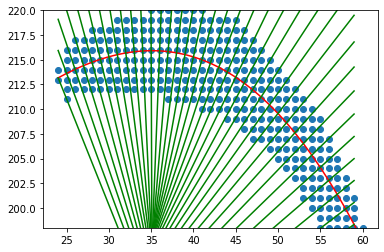

In [52]:
plt.scatter(x, y)
ax = plt.gca()
# ax.plot(x, fun(x), c='r')
ax.plot(x, fun, c='r')
# ax.plot(x, poly.polyval(40, z) - (1 / poly.polyval(40, der)) * (x - 40))
for normal in normals:
    ax.plot(new_x, normal, c='green')
plt.ylim((min(y), max(y)))
plt.show()

In [53]:
df = pd.DataFrame(layers[0], columns=['x', 'y'])

In [54]:
len(normals), len(normals[0]), len(new_x)

(36, 36, 36)

In [77]:
outline_points = np.zeros(len(normals), dtype=object)
# Idee: erster trace geht nicht nach [-1, slope]/[1, -slope], sondern nach [0, slope]/[0, -slope]
def trace(p, v, tolerance):
    point = None
    alpha = 1
    while True:
        g = p + alpha * v
        points = df.loc[abs(df['x'] - g[0]) <= tolerance].loc[abs(df['y'] - g[1]) <= tolerance]
        if points.shape[0] == 0:
            break
        
        point = points.iloc[0].to_numpy()
        alpha += 1
    
    return point
    
for i in range(len(normals)):
# for i in range(1):
    # i = 15
    x0 = new_x[i]
    normal = normals[i]
    intercept = normal[i]
    slope = -(normal[0] - normal[1])
    p = np.array([x0, intercept])
    v1 = np.array([-1, -slope]) * .1
    v2 = np.array([1, slope]) * .1
    point_1 = None
    point_2 = None
    for j in range(10):
        point_1 = trace(p, v1, j)
        if point_1 is not None:
            break

    for j in range(10):
        point_2 = trace(p, v2, j)
        if point_2 is not None:
            break
    
    outline_points[i] = np.array([point_1, point_2])

outline_points

array([array([[ 24, 214],
              [ 25, 211]]), array([[ 25, 215],
                                   [ 26, 212]]), array([[ 25, 216],
                                                        [ 27, 212]]),
       array([[ 26, 217],
              [ 28, 212]]), array([[ 26, 217],
                                   [ 29, 212]]), array([[ 28, 218],
                                                        [ 30, 212]]),
       array([[ 29, 218],
              [ 30, 212]]), array([[ 31, 219],
                                   [ 31, 212]]), array([[ 31, 219],
                                                        [ 32, 212]]),
       array([[ 32, 219],
              [ 33, 212]]), array([[ 33, 219],
                                   [ 34, 212]]),
       array([None, None], dtype=object), array([[ 35, 212],
                                                 [ 36, 220]]),
       array([[ 37, 211],
              [ 37, 220]]), array([[ 37, 211],
                                   [ 38, 220]]),

In [78]:
indices = []
for i in range(len(outline_points)):
    if None in outline_points[i]:
        indices.append(i)

outline_points = np.delete(outline_points, indices)
outline_points

array([array([[ 24, 214],
              [ 25, 211]]), array([[ 25, 215],
                                   [ 26, 212]]), array([[ 25, 216],
                                                        [ 27, 212]]),
       array([[ 26, 217],
              [ 28, 212]]), array([[ 26, 217],
                                   [ 29, 212]]), array([[ 28, 218],
                                                        [ 30, 212]]),
       array([[ 29, 218],
              [ 30, 212]]), array([[ 31, 219],
                                   [ 31, 212]]), array([[ 31, 219],
                                                        [ 32, 212]]),
       array([[ 32, 219],
              [ 33, 212]]), array([[ 33, 219],
                                   [ 34, 212]]), array([[ 35, 212],
                                                        [ 36, 220]]),
       array([[ 37, 211],
              [ 37, 220]]), array([[ 37, 211],
                                   [ 38, 220]]), array([[ 37, 211],
               

In [69]:
new_x

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59])

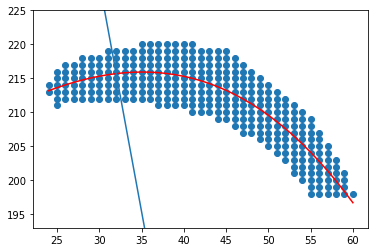

In [70]:
indx = 8
plt.scatter(x, y)
ax = plt.gca()
ax.plot(x, fun, c='r')
ax.plot(new_x, poly.polyval(new_x[indx], z) - (1 / poly.polyval(new_x[indx], der)) * (new_x - new_x[indx]))
#ax.scatter(point_1[0], point_1[1], color='red')
#ax.scatter(point_2[0], point_2[1], color='orange')
plt.ylim((min(y) - 5, max(y) + 5))
plt.show()

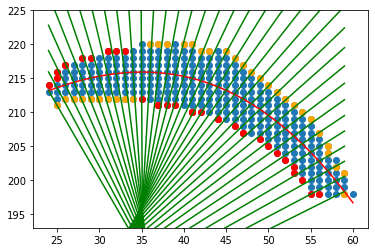

In [79]:
plt.scatter(x, y)
ax = plt.gca()
ax.plot(x, fun, c='r')
for i in range(len(normals)):
    ax.plot(new_x, normals[i], c='green')

for i in range(len(outline_points)):
    ax.scatter(outline_points[i][0][0], outline_points[i][0][1], color='red')
    ax.scatter(outline_points[i][1][0], outline_points[i][1][1], color='orange')
    
plt.ylim((min(y) - 5, max(y) + 5))
plt.show()

In [80]:
distances = 0
for point in outline_points:
    distances += utility.vector_distance(point[0], point[1])

distances = distances / len(outline_points)
distances

6.802214107691905